In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]
DATASET_VERSION = "06"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-bce-dsv{DATASET_VERSION}-full")
SUB_PATH = Path(f"../data/subs/lgbm-dart-bce-dsv{DATASET_VERSION}-full")
ART_PATH = Path(f"../artifacts/lgbm-dart-bce-dsv{DATASET_VERSION}-full")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
len(input_feats)

1308

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

36

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting': 'dart',
    'objective': 'binary',
    'metric': 'None',
    'num_iterations': 4350,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'max_bin': 63,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 1.0,
    'feature_fraction': 0.15,
    'lambda_l1': 5.996099571922015,
    'lambda_l2': 2.8900783163910697,
    'min_data_in_leaf': 1000,
    'path_smooth': 1.476306537276899,
    'min_gain_to_split': 0.313937968985787,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': True,
    'verbosity': -1,
    # dropout params
    'drop_rate': 0.1,
    'max_drop': 40,
    'skip_drop': 0.7,
}

In [9]:
def train_model(dataframe:pd.DataFrame, model_params:dict) -> lgb.Booster:         
    train_dset = lgb.Dataset(
        data=dataframe.loc[:,input_feats],
        label=dataframe.loc[:,"target"].values,
        free_raw_data=True,
    )
    model = lgb.train(
        params=model_params,
        train_set=train_dset,
    )
    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()        

    del train_dset
    gc.collect()
    
    return model

################################################################################
############################ Training model 1 of 15 ############################
################################################################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


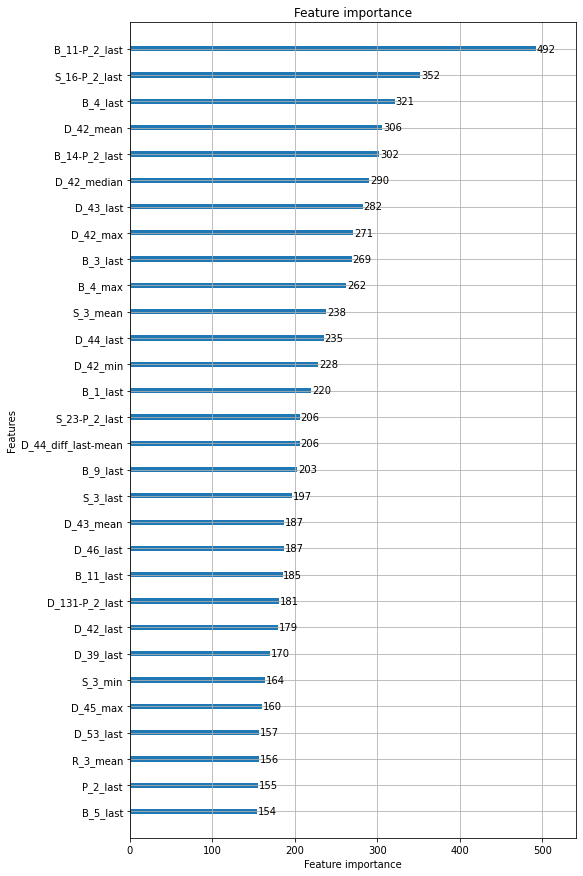

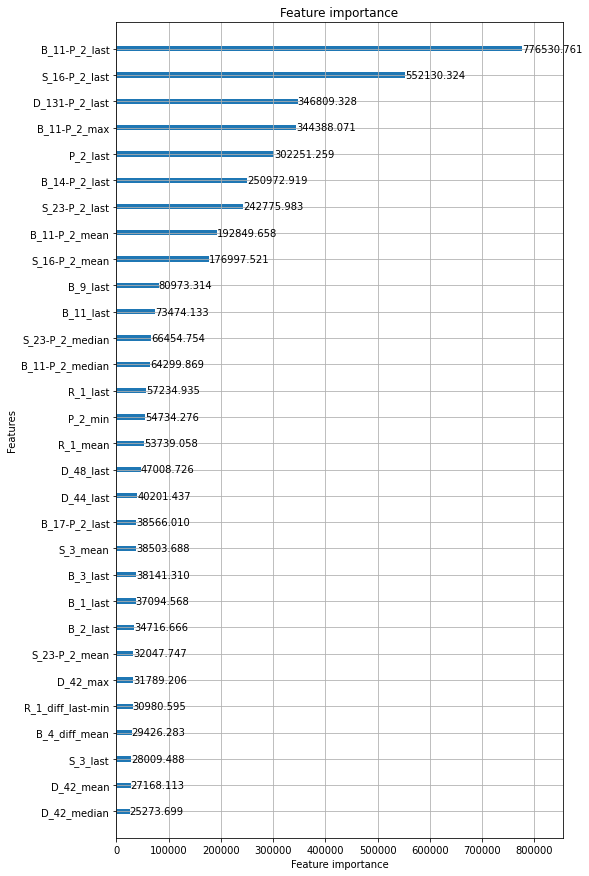

Training time: 7.544006864229838 min.
################################################################################
############################ Training model 2 of 15 ############################
################################################################################


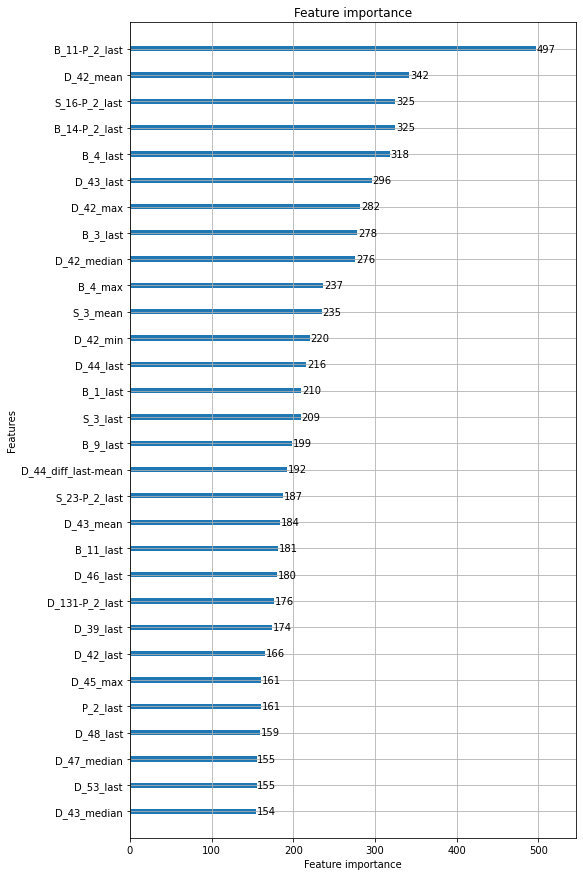

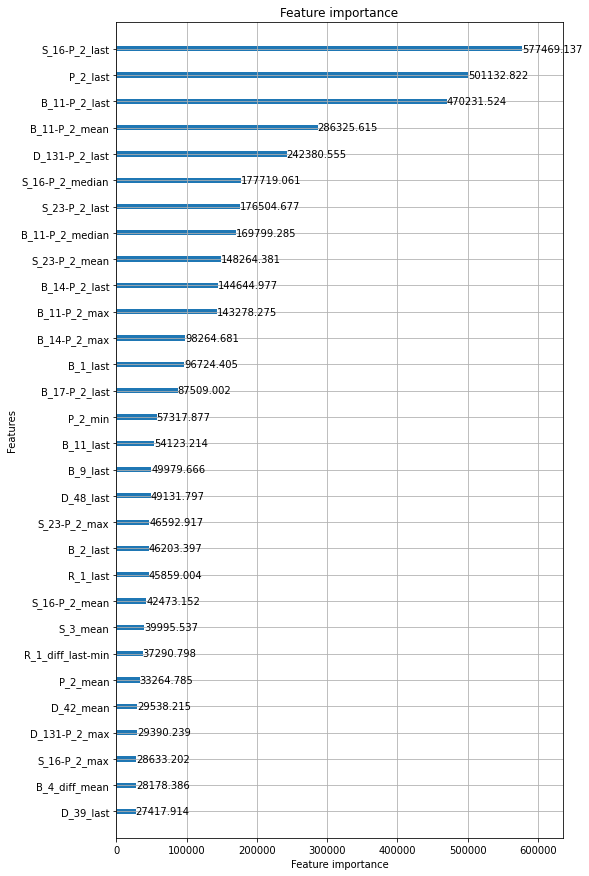

Training time: 7.422111984093984 min.
################################################################################
############################ Training model 3 of 15 ############################
################################################################################


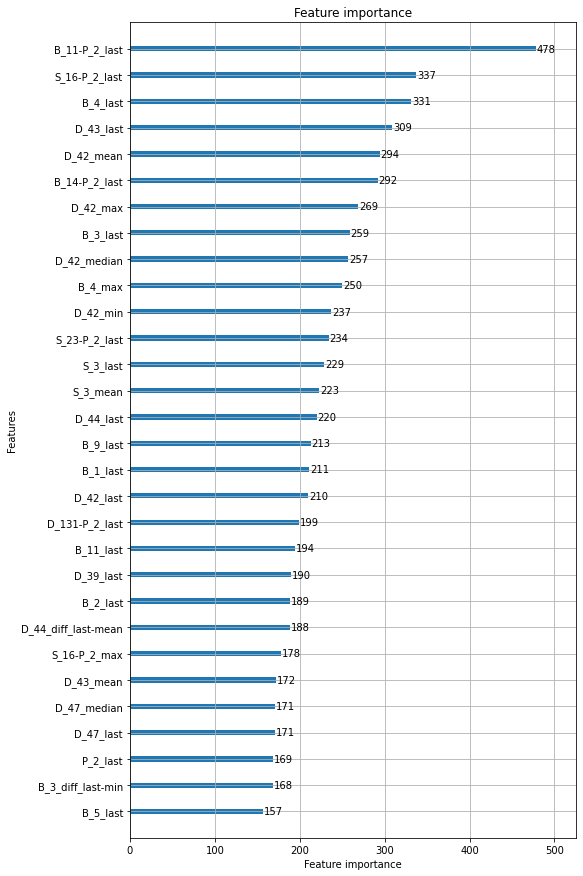

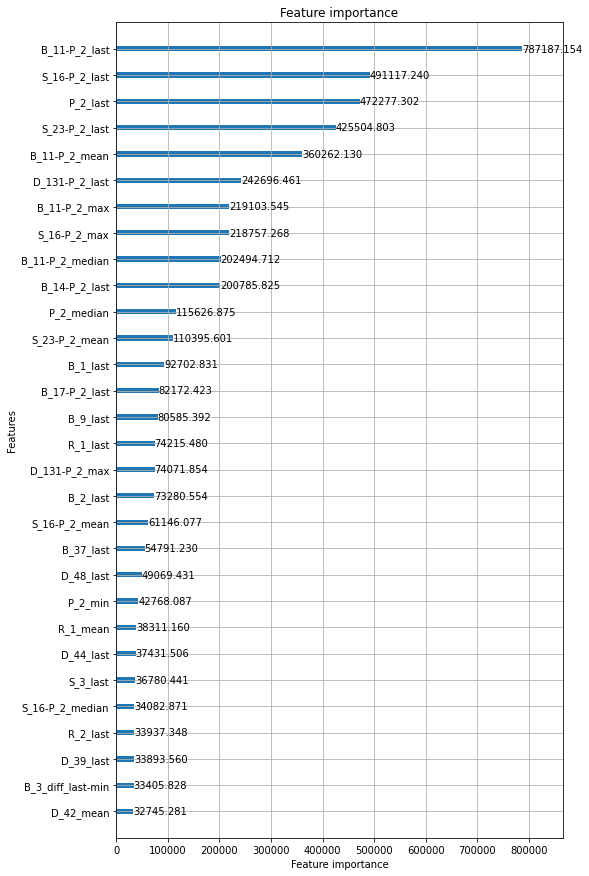

Training time: 7.3866755565007525 min.
################################################################################
############################ Training model 4 of 15 ############################
################################################################################


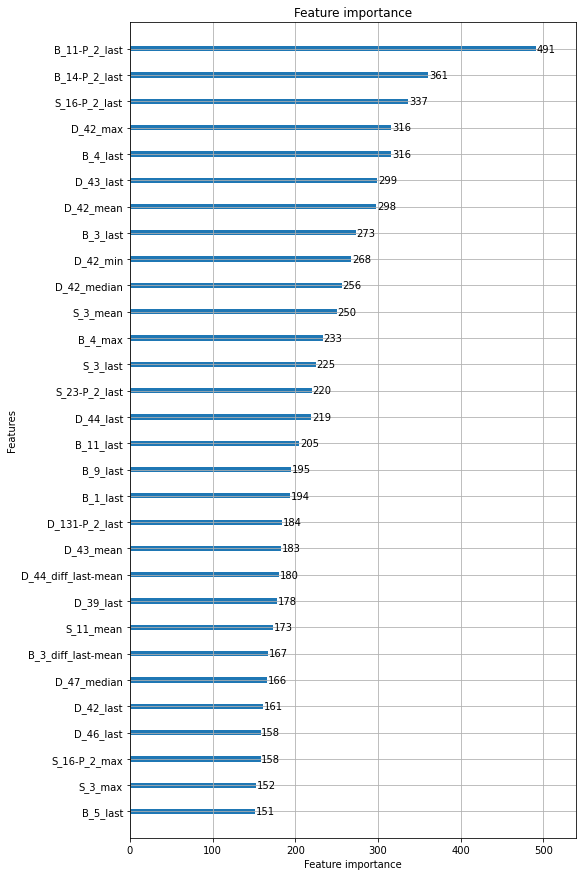

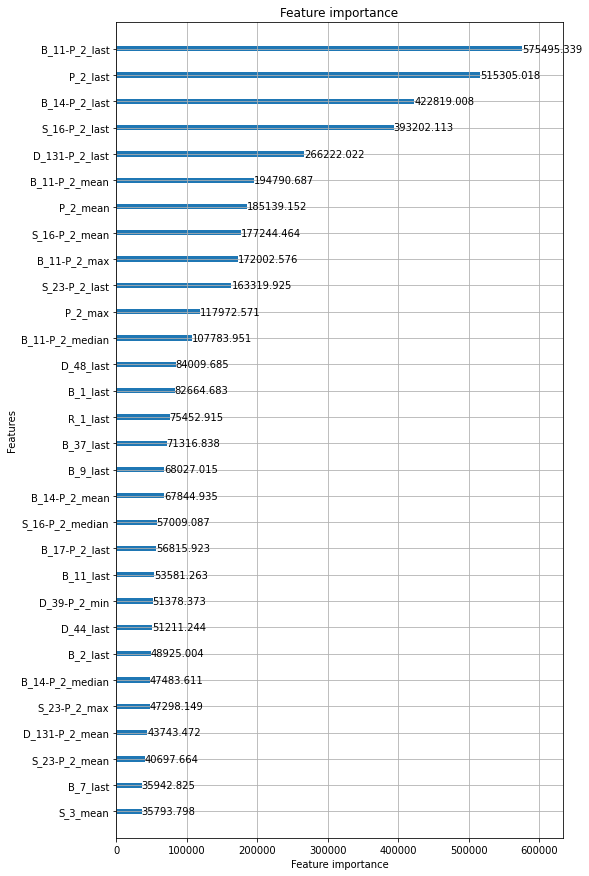

Training time: 7.470431427160899 min.
################################################################################
############################ Training model 5 of 15 ############################
################################################################################


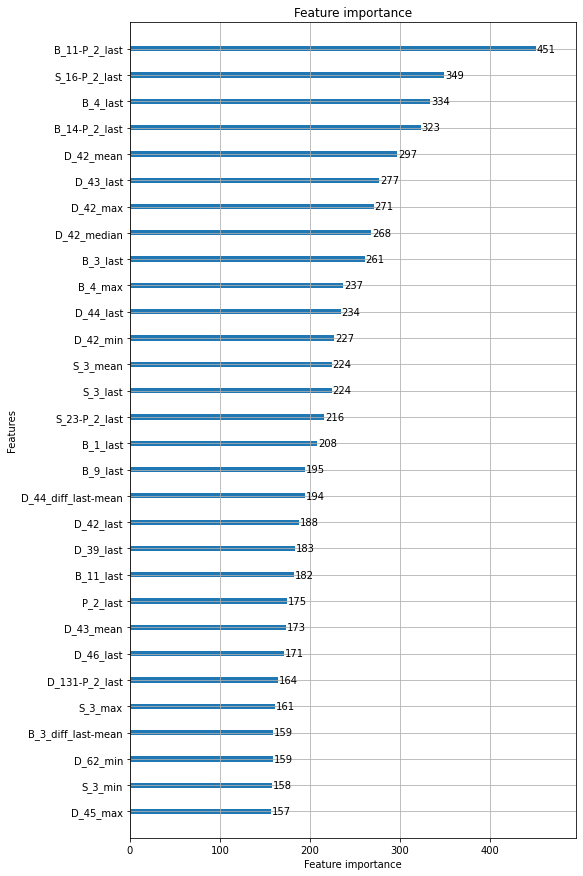

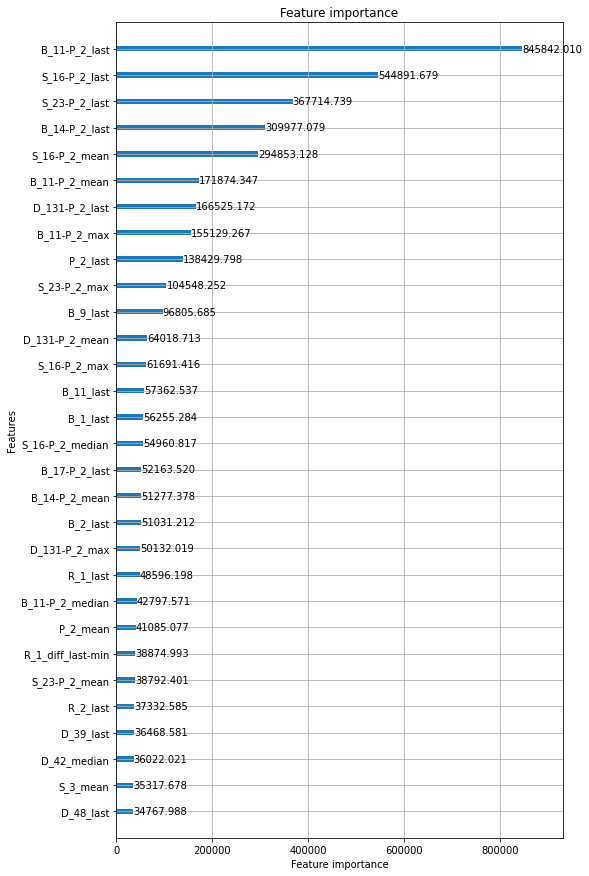

Training time: 7.293997947374979 min.
################################################################################
############################ Training model 6 of 15 ############################
################################################################################


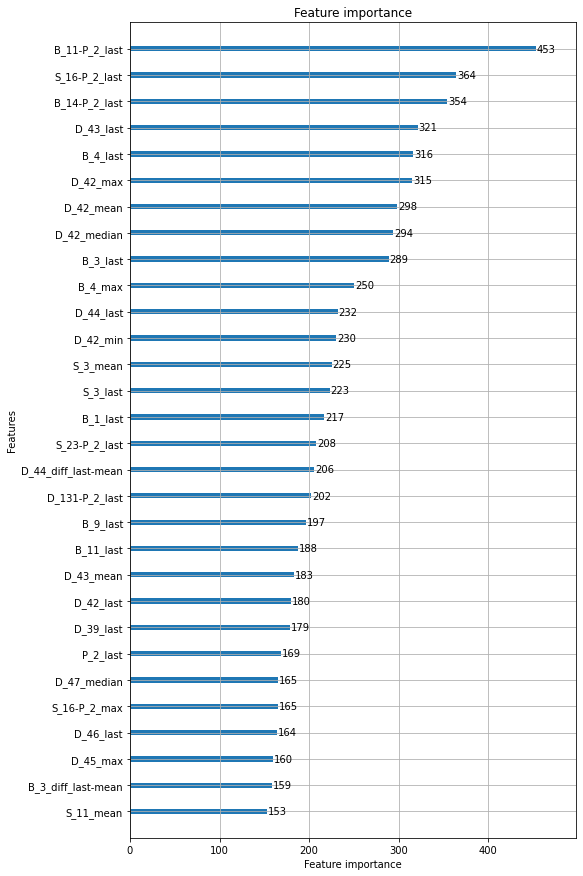

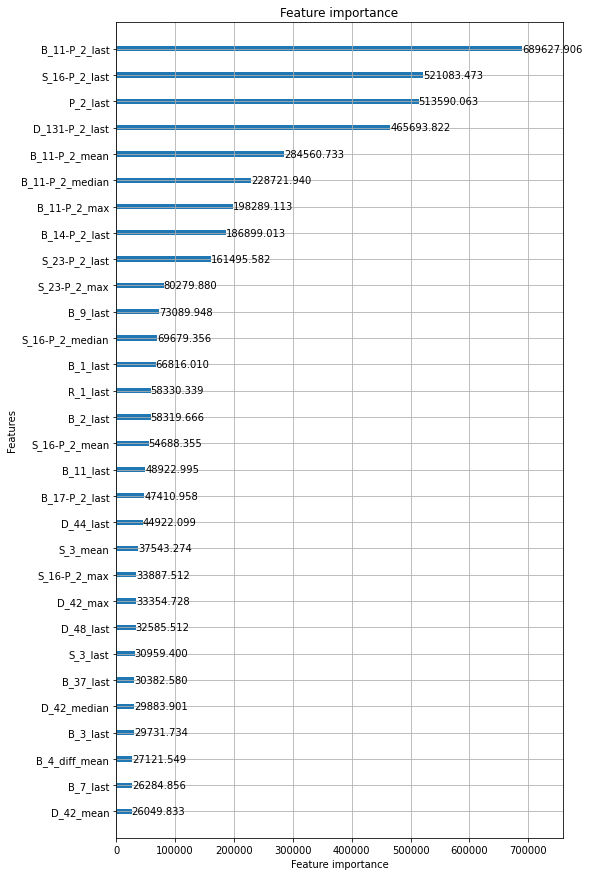

Training time: 7.398939148585002 min.
################################################################################
############################ Training model 7 of 15 ############################
################################################################################


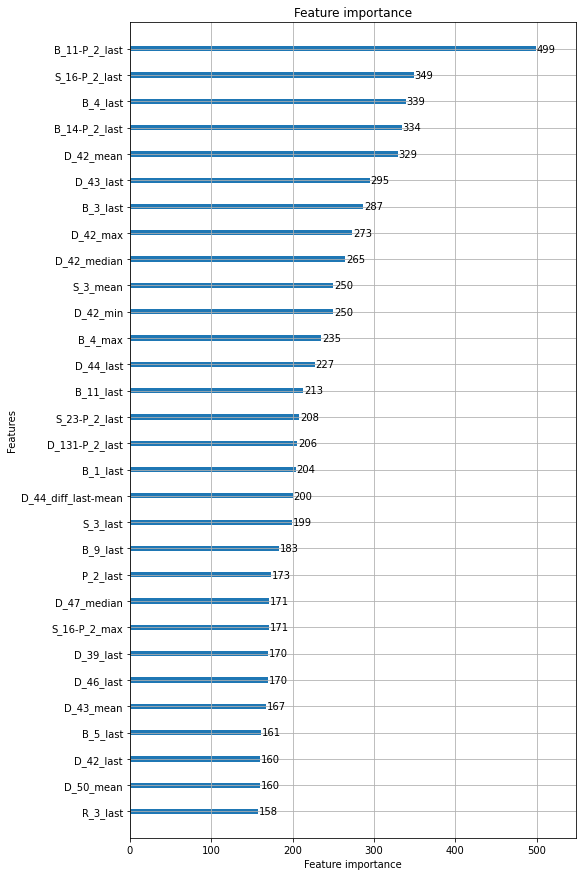

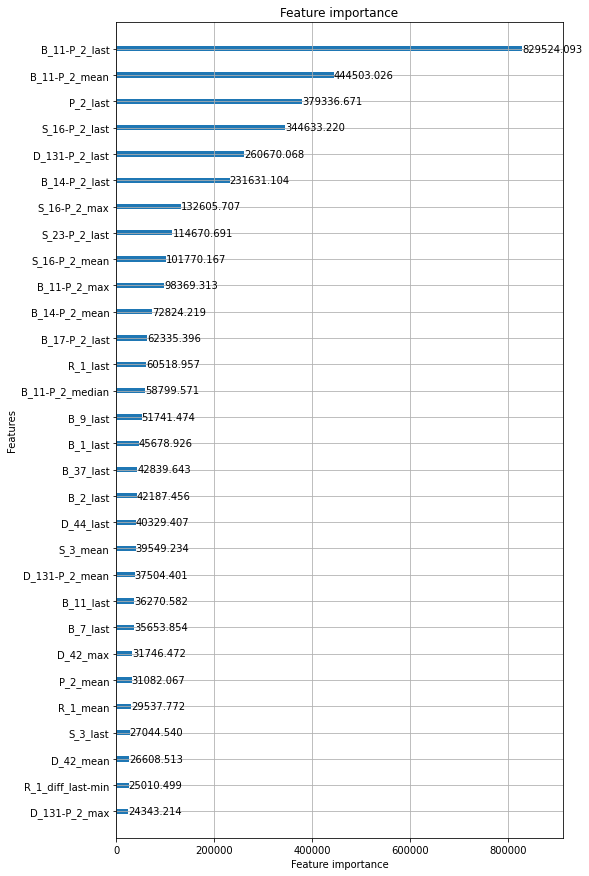

Training time: 7.410872979958852 min.
################################################################################
############################ Training model 8 of 15 ############################
################################################################################


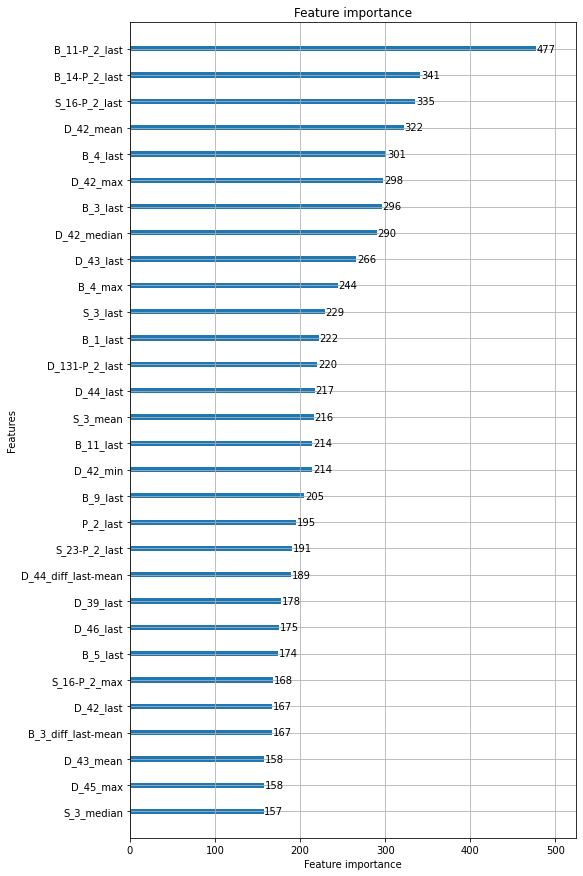

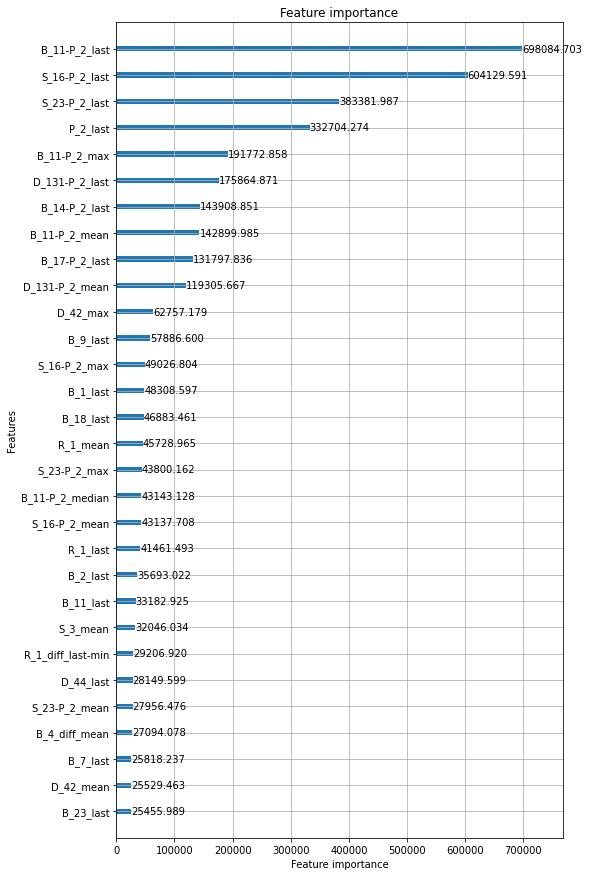

Training time: 7.4501237869262695 min.
################################################################################
############################ Training model 9 of 15 ############################
################################################################################


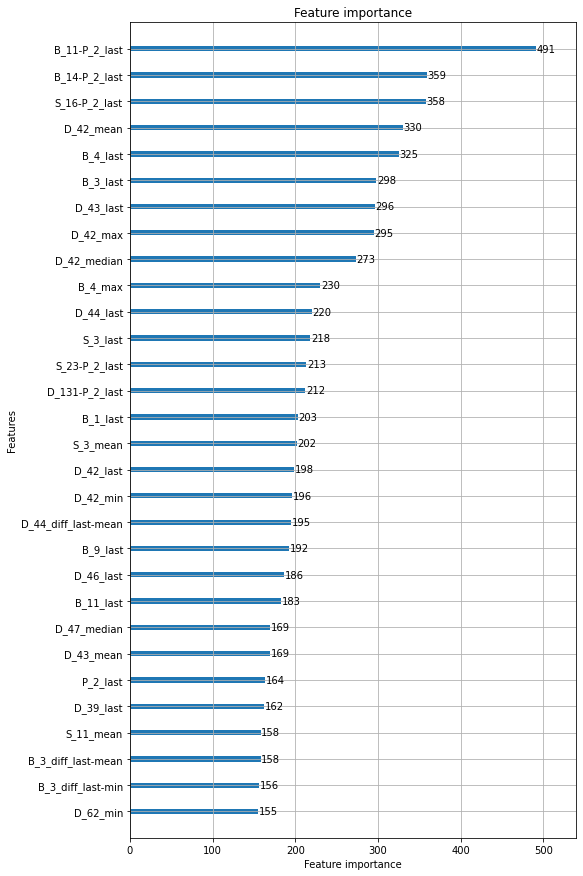

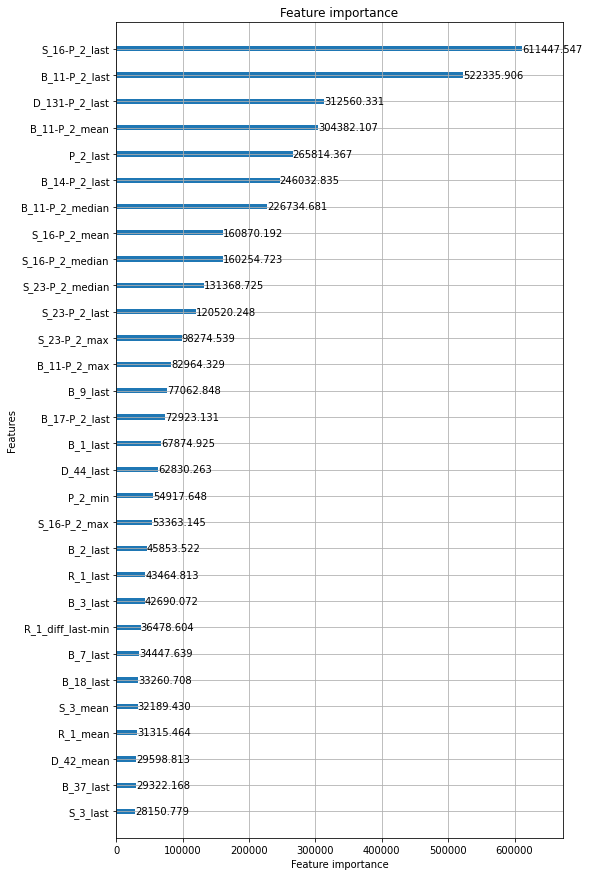

Training time: 7.36635730266571 min.
################################################################################
########################### Training model 10 of 15 ############################
################################################################################


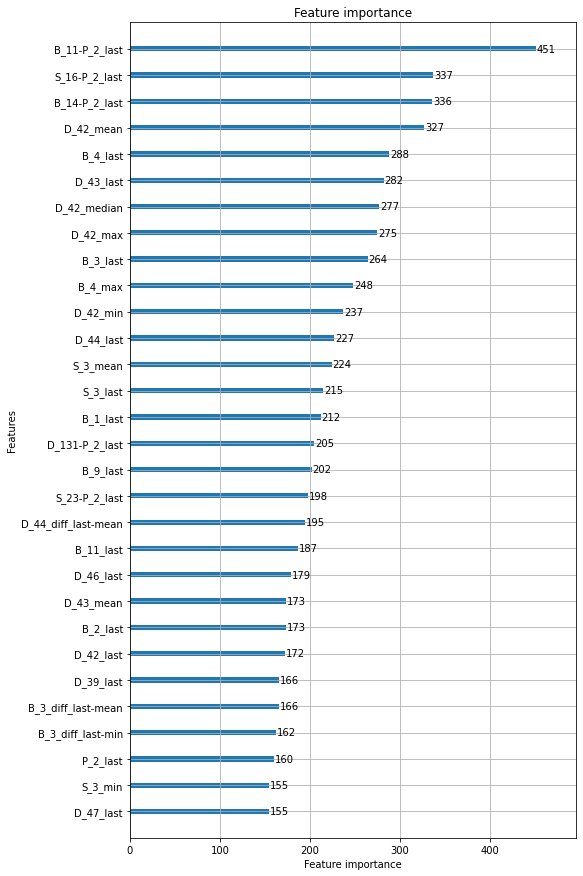

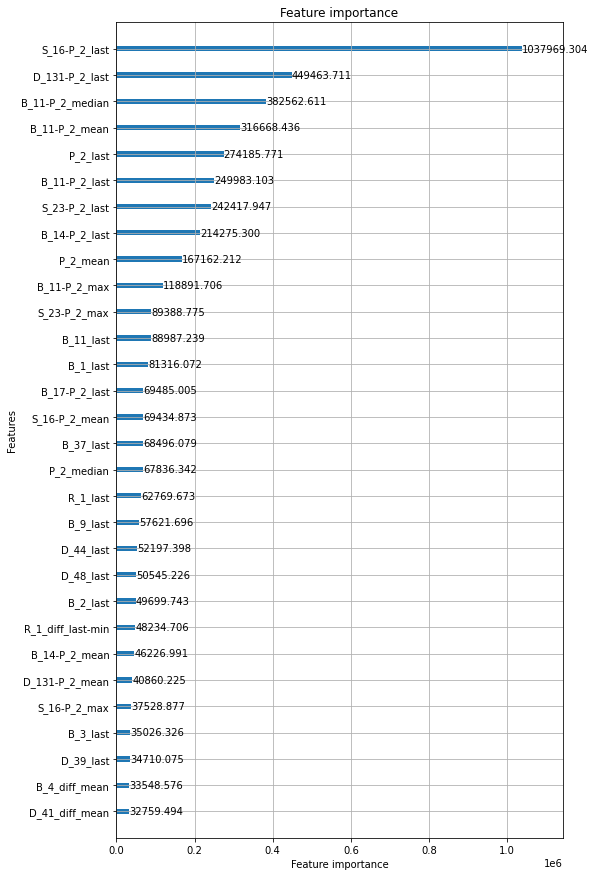

Training time: 7.3014575958251955 min.
################################################################################
########################### Training model 11 of 15 ############################
################################################################################


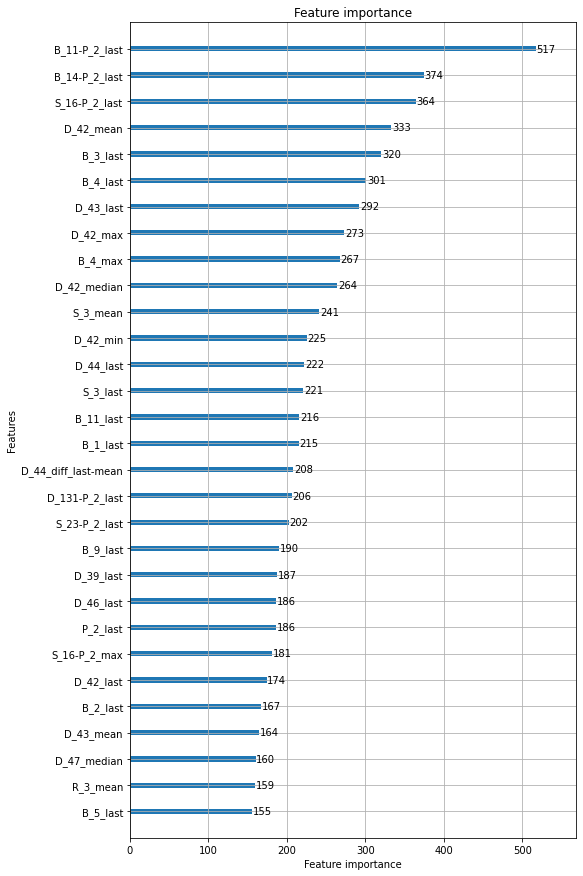

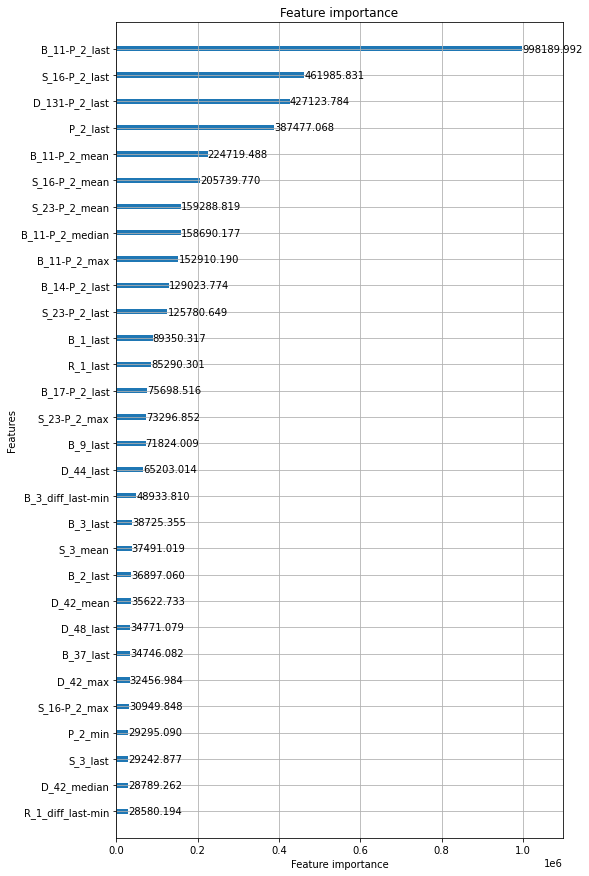

Training time: 7.483154114087423 min.
################################################################################
########################### Training model 12 of 15 ############################
################################################################################


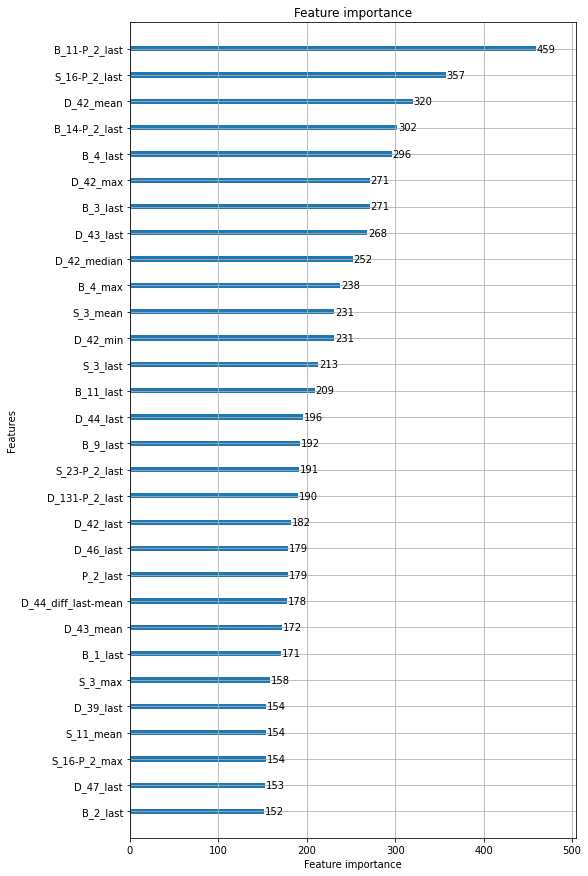

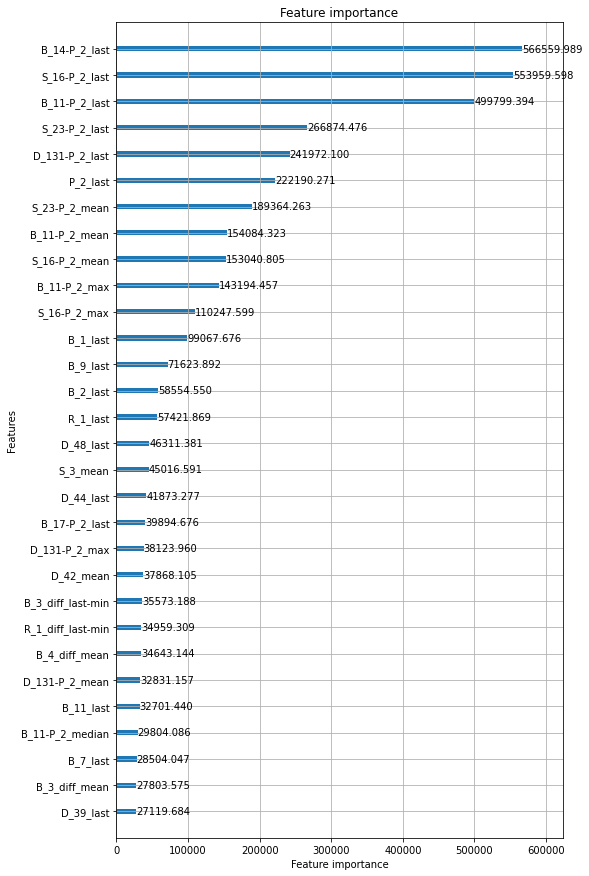

Training time: 7.208584439754486 min.
################################################################################
########################### Training model 13 of 15 ############################
################################################################################


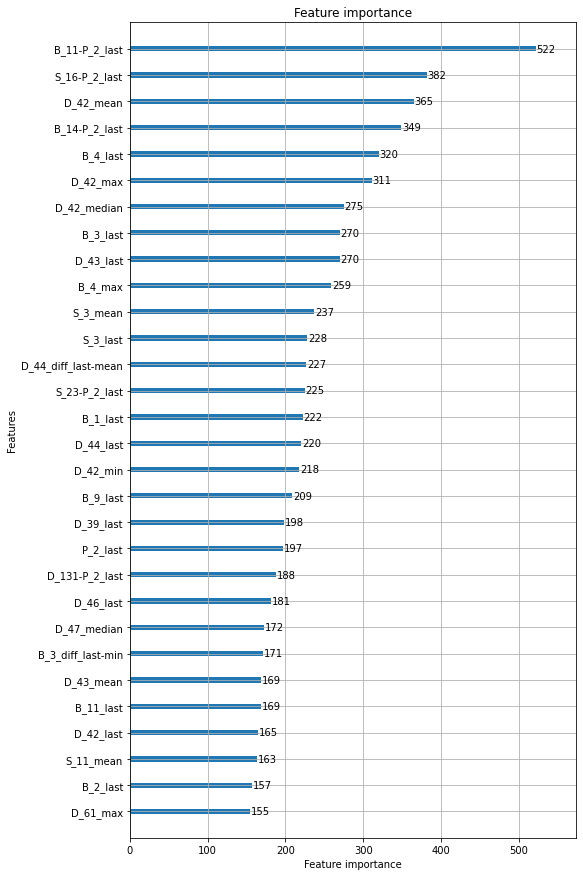

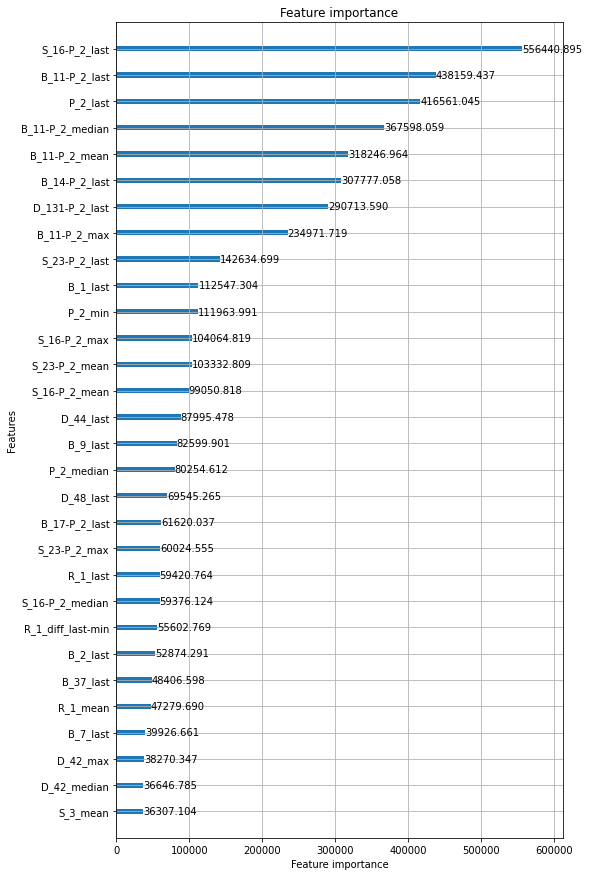

Training time: 7.512801535924276 min.
################################################################################
########################### Training model 14 of 15 ############################
################################################################################


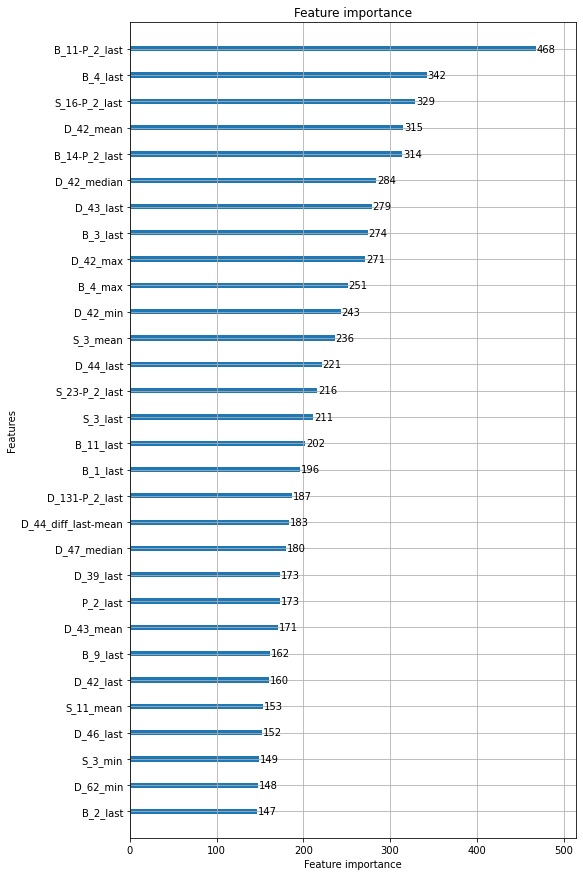

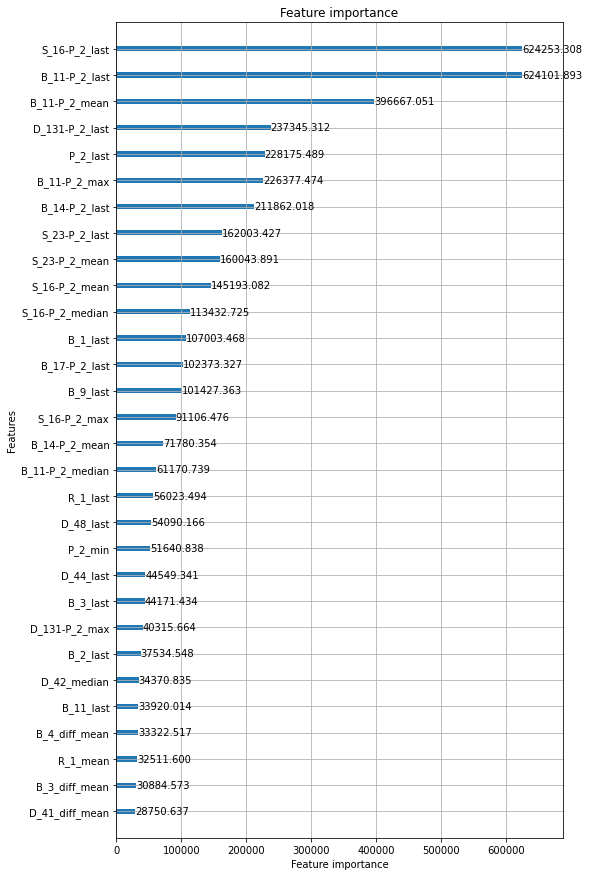

Training time: 7.283123886585235 min.
################################################################################
########################### Training model 15 of 15 ############################
################################################################################


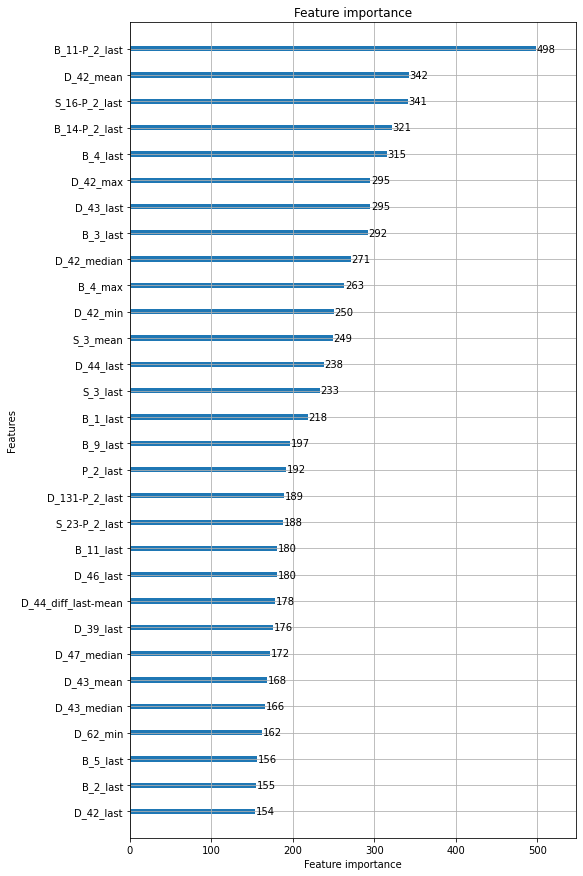

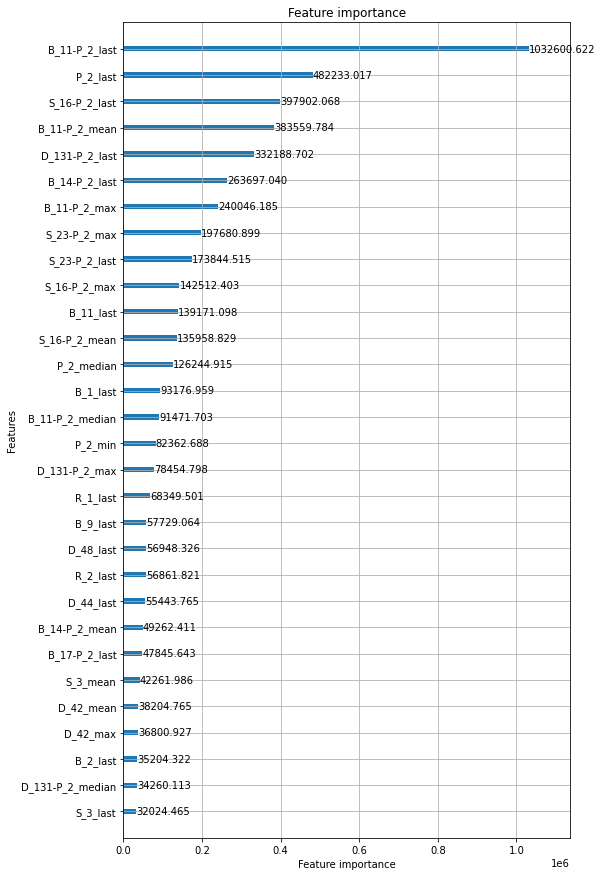

Training time: 7.517748109499613 min.


CPU times: user 1d 11h 17min 43s, sys: 1min 36s, total: 1d 11h 19min 19s
Wall time: 1h 51min 3s


In [10]:
%%time 

all_models = list()

for it,seed in enumerate(SEEDS):
    print("#"*80)
    print(f" Training model {it+1} of {len(SEEDS)} ".center(80, "#"))
    print("#"*80)
    
    _model_params = dict(model_params)
    _model_params["seed"] = seed
    
    tic = time.time()
    model = train_model(train, _model_params)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
    
    all_models.append(model)
    
# save models
for seed,_model in zip(SEEDS,all_models):
    _model.save_model(ART_PATH/f"model-seed{str(seed).zfill(2)}.txt")

In [11]:
del train
gc.collect()

21

***
## make predictions and submit

In [12]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [13]:
%%time

all_preds = list()

for seed,model in zip(SEEDS,all_models):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    preds = model.predict(test[input_feats])
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-seed{str(seed).zfill(2)}.csv", index=False)

CPU times: user 1h 44min 42s, sys: 58.6 s, total: 1h 45min 41s
Wall time: 8min 15s


In [14]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.48 s, sys: 777 ms, total: 4.26 s
Wall time: 4.26 s


***